<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li><li><span><a href="#CatBoost-Regressor" data-toc-modified-id="CatBoost-Regressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost Regressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

Цель исследования — спрогнозировать количество заказов такси на следующий час.

Данные получим из файла taxi.csv.

Исследование пройдёт в четыре этапа:

* Подготовка
* Анализ данных
* Обучение
* Анализ моделей
* Тестирование

## Подготовка

In [1]:
# Импорт необходимых библиотек


import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import time

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
# Константы


r_state = 12345
figsize = (15,7)

In [3]:
# Функции и классы


# Функция для получения общих сведений о данных

def data_info(title, data):
    
    print('Общие сведения "{}":'.format(title))
    print()
    
    data.info()
    
    print()
    print()
    
    print('Пример данных (случайные 5 строк):')
    display(data.sample(5, random_state=r_state))

    print()
    print()
    
    print('Количество пропусков по столбцам:')
    print()
    for col in data.columns:
        nmv = data[col].isna().sum()
        pmv = nmv/len(data)
        
        if pmv == 0:
            print('\033[0m{} - {} шт. - {:.2%}'.format(col, nmv, pmv))
        elif pmv <= 0.1:
            print('\033[0m{} - \033[43m{} шт.\033[0m - \033[43m{:.2%}'.format(col, nmv, pmv))
        else:
            print('\033[0m{} - \033[41m{} шт.\033[0m - \033[41m{:.2%}'.format(col, nmv, pmv))
        print('\033[0m')
    
    print()
    
    print('Количество уникальных значений в столбцах:')
    print()
    for col in data.columns:
        print('{} - {}'.format(col, data[col].nunique()))
        
    print()
    print()
    
    print('Проверка хронологического порядка даты и времени:')
    print()
    if data.index.is_monotonic == True:
        print('Данные отсортированы в хронологическом порядке')
    else:
        print('Необходимо отсортировать данные')

# Функция для подсчета RMSE

def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

# Класс для сохранения статистики обучения моделей (время обучения, время предсказания и RMSE)

class ModelStat:
    
    def __init__(self, name, model):
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start_time = time.time()    
        self.model.fit(features, target)
        end_time = time.time() - start_time
        self.fit_time = end_time
    
    def predict(self, features, target):
        start_time = time.time()  
        self.predicted = self.model.predict(features)
        end_time = time.time() - start_time
        self.predict_time = end_time
        self.rmse = rmse(target, self.predicted)
    
    def predicted(self):
        return self.predicted
        
    def getResult(self):
        return self.name,  round(self.rmse, 5)

In [4]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

## Анализ данных

In [5]:
data_info('data', data)

Общие сведения "data":

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пример данных (случайные 5 строк):


,num_orders
datetime,
2018-06-04 05:50:00,5
2018-07-26 10:20:00,24
2018-07-25 20:00:00,20
2018-05-04 18:50:00,9
2018-05-12 11:00:00,18




Количество пропусков по столбцам:

num_orders - 0 шт. - 0.00%


Количество уникальных значений в столбцах:

num_orders - 81


Проверка хронологического порядка даты и времени:

Данные отсортированы в хронологическом порядке


Описание данных:

* Данные состоят из 26496 объектов
* Имеют 1 признак - num_orders (Количество заказов)
* Содержат информацию с 00:00:00 1 марта 2018 года по 23:50:00 31 августа 2018 года
* Пропуски отсутствуют
* Данные отсортированы в хронологическом порядке

Ресемплируем данные по одному часу

In [6]:
data = data.resample('1H').sum()

Построим график с разбивкой по одному часу

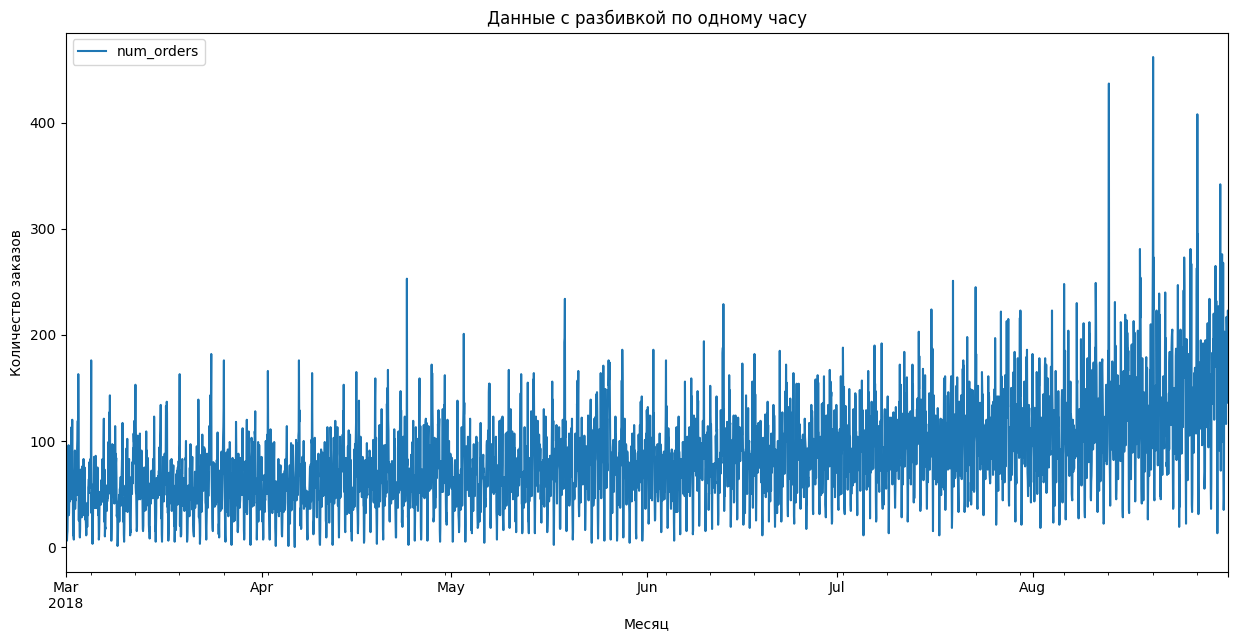

In [7]:
data.plot(figsize=figsize);
plt.title('Данные с разбивкой по одному часу')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последний месяц

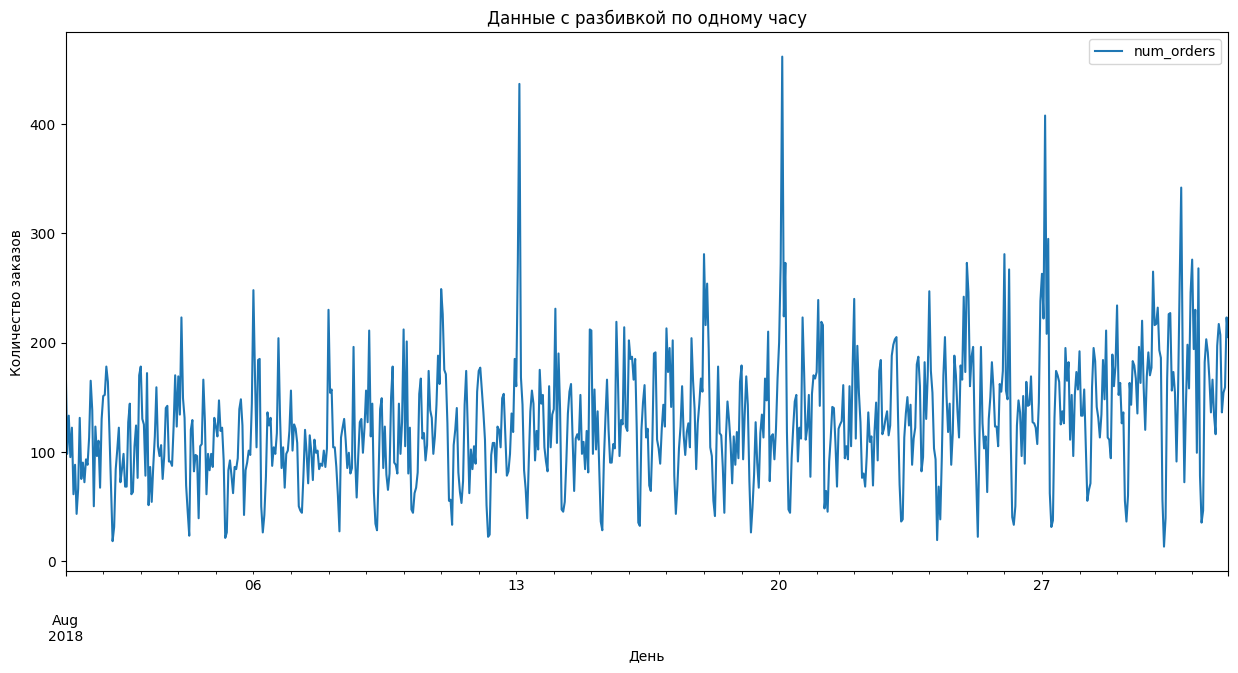

In [8]:
data['2018-08-01':].plot(figsize=figsize);
plt.title('Данные с разбивкой по одному часу')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последнюю неделю

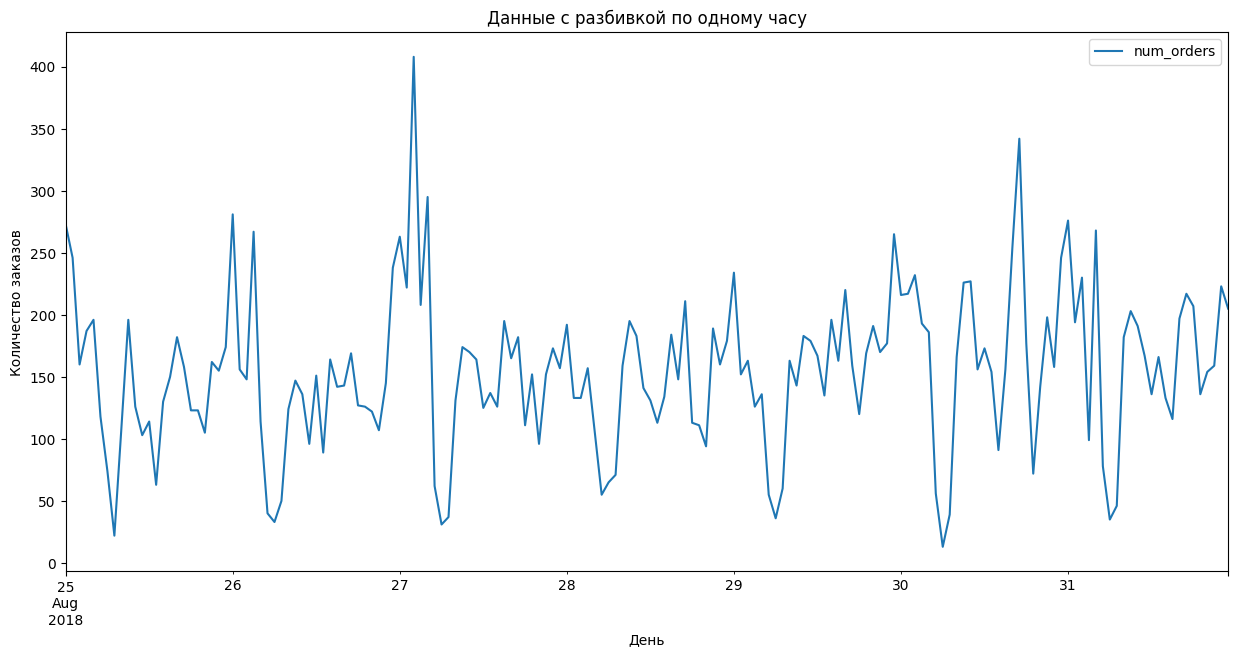

In [9]:
data['2018-08-25':].plot(figsize=figsize);
plt.title('Данные с разбивкой по одному часу')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последние 2 дня

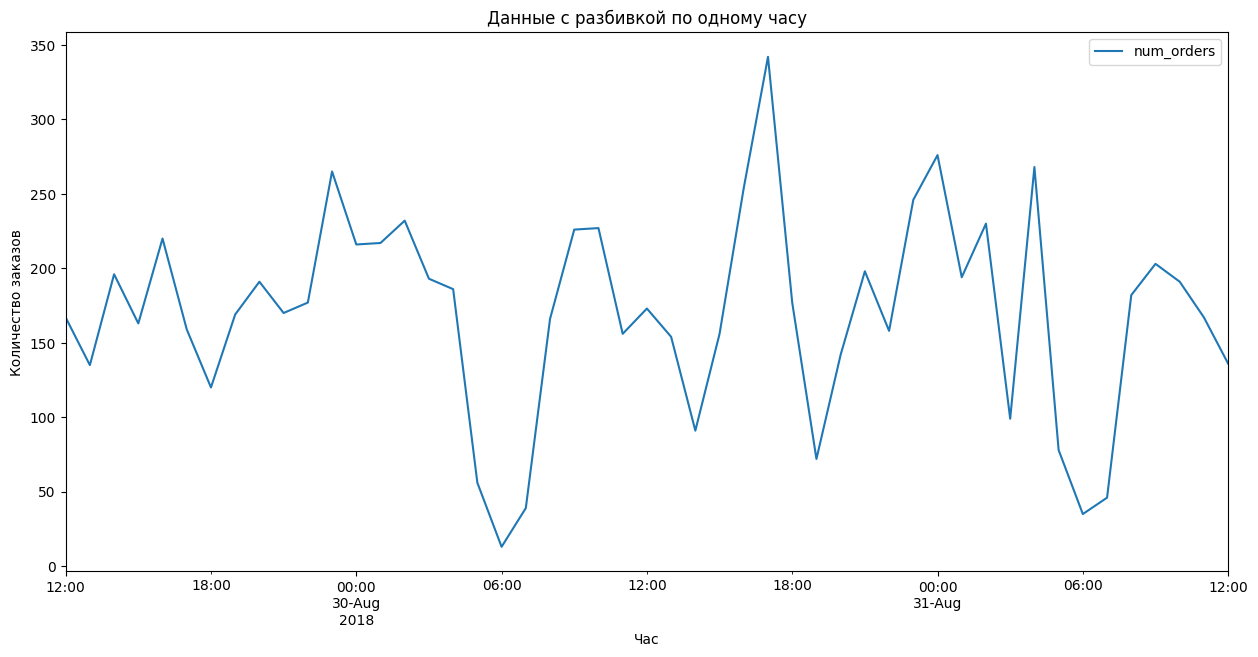

In [10]:
data['2018-08-29 12:00:00':'2018-08-31 12:00:00'].plot(figsize=figsize);
plt.title('Данные с разбивкой по одному часу')
plt.xlabel('Час')
plt.ylabel('Количество заказов')
plt.show()

Найдем скользящее среднее и стандартное отклонение

In [11]:
data['rolling_mean'] = data['num_orders'].shift().rolling(12).mean()
data['rolling_std'] = data['num_orders'].rolling(12).std()
data = data.dropna()

Построим график с разбивкой по одному часу

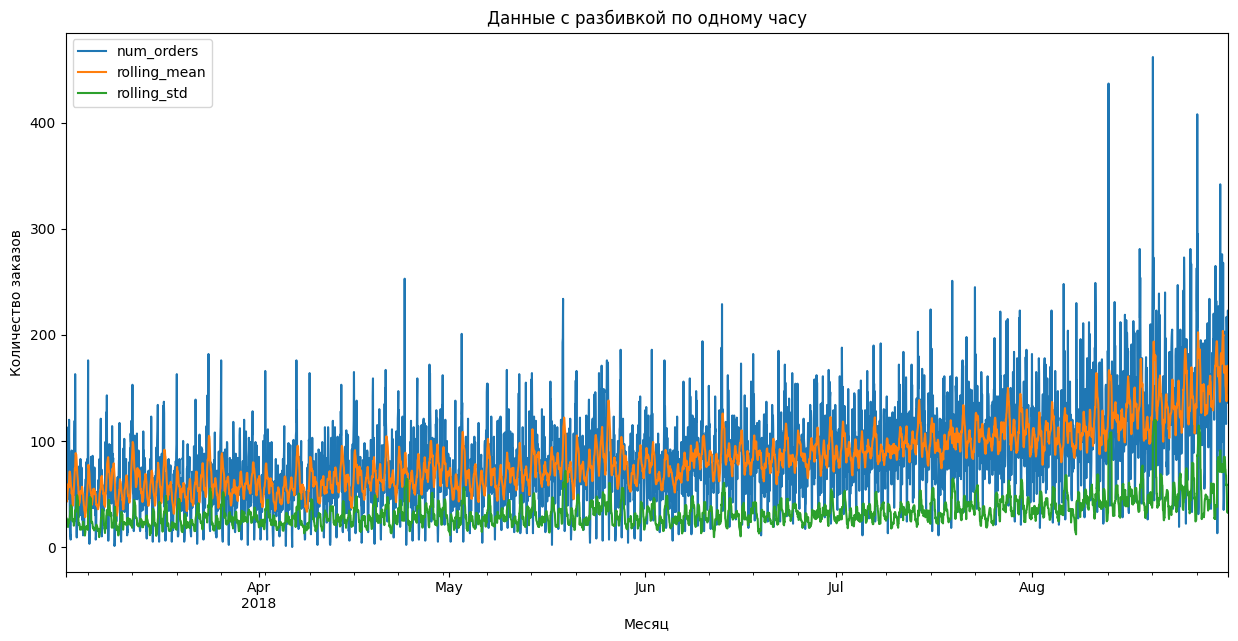

In [12]:
data[['num_orders', 'rolling_mean', 'rolling_std']].plot(figsize=figsize);
plt.title('Данные с разбивкой по одному часу')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последний месяц

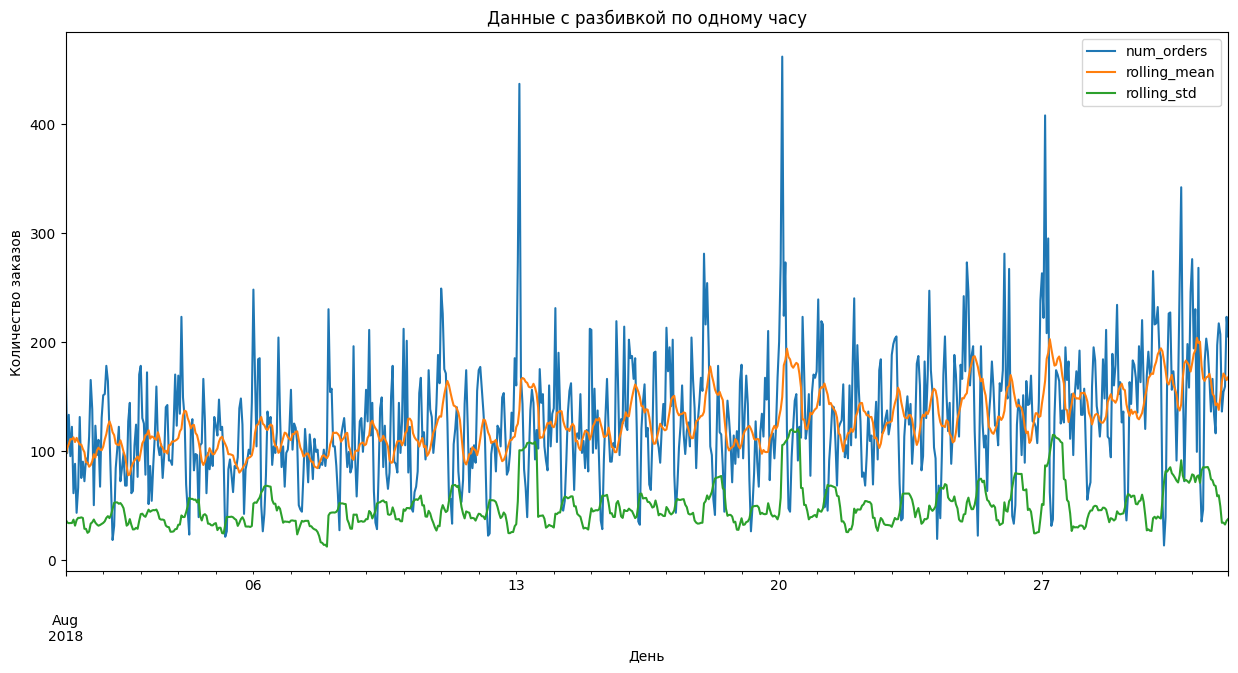

In [13]:
data['2018-08-01':][['num_orders', 'rolling_mean', 'rolling_std']].plot(figsize=figsize);
plt.title('Данные с разбивкой по одному часу')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последнюю неделю

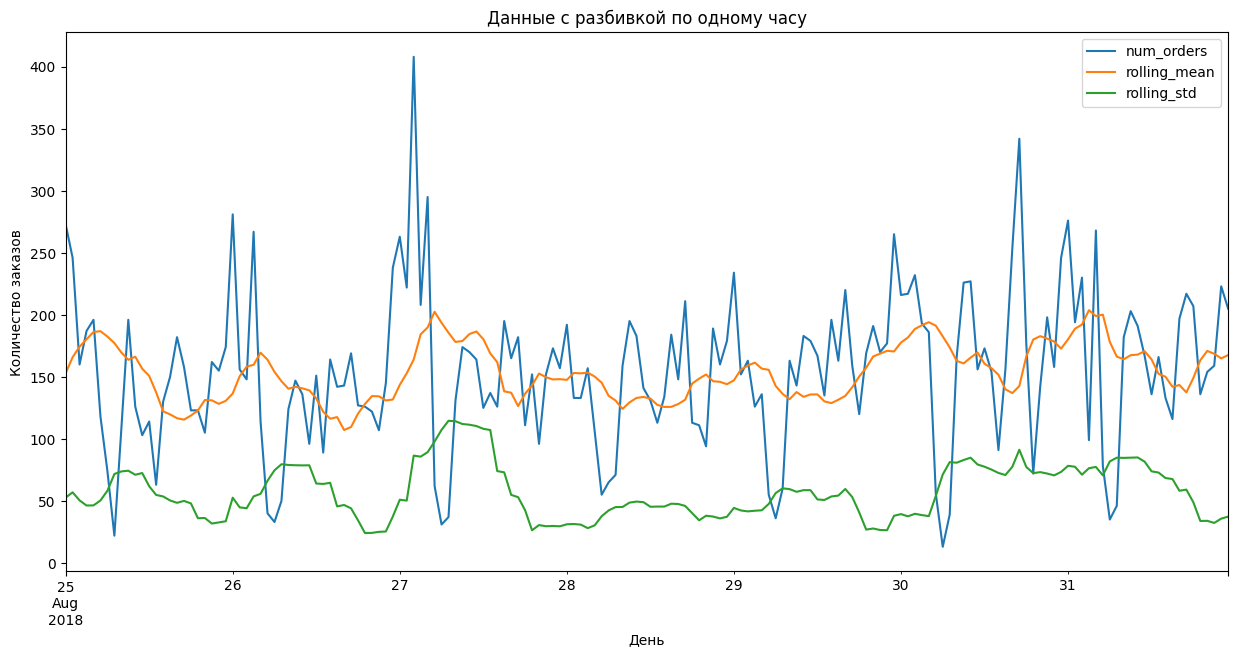

In [14]:
data['2018-08-25':][['num_orders', 'rolling_mean', 'rolling_std']].plot(figsize=figsize);
plt.title('Данные с разбивкой по одному часу')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последние 2 дня

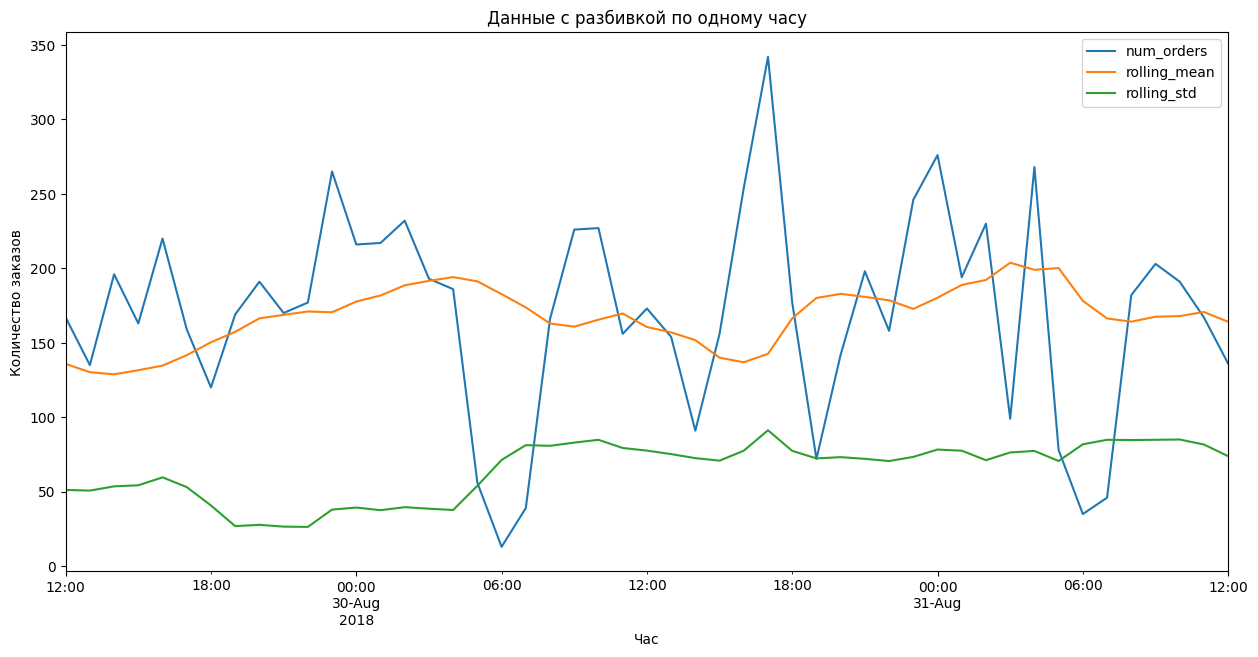

In [15]:
data['2018-08-29 12:00:00':'2018-08-31 12:00:00'][['num_orders', 'rolling_mean', 'rolling_std']].plot(figsize=figsize);
plt.title('Данные с разбивкой по одному часу')
plt.xlabel('Час')
plt.ylabel('Количество заказов')
plt.show()

Проведем декомпозицию для просмотра тренда и сезонности

In [16]:
decomposed_data = seasonal_decompose(data['num_orders'])

Построим график с разбивкой по одному часу

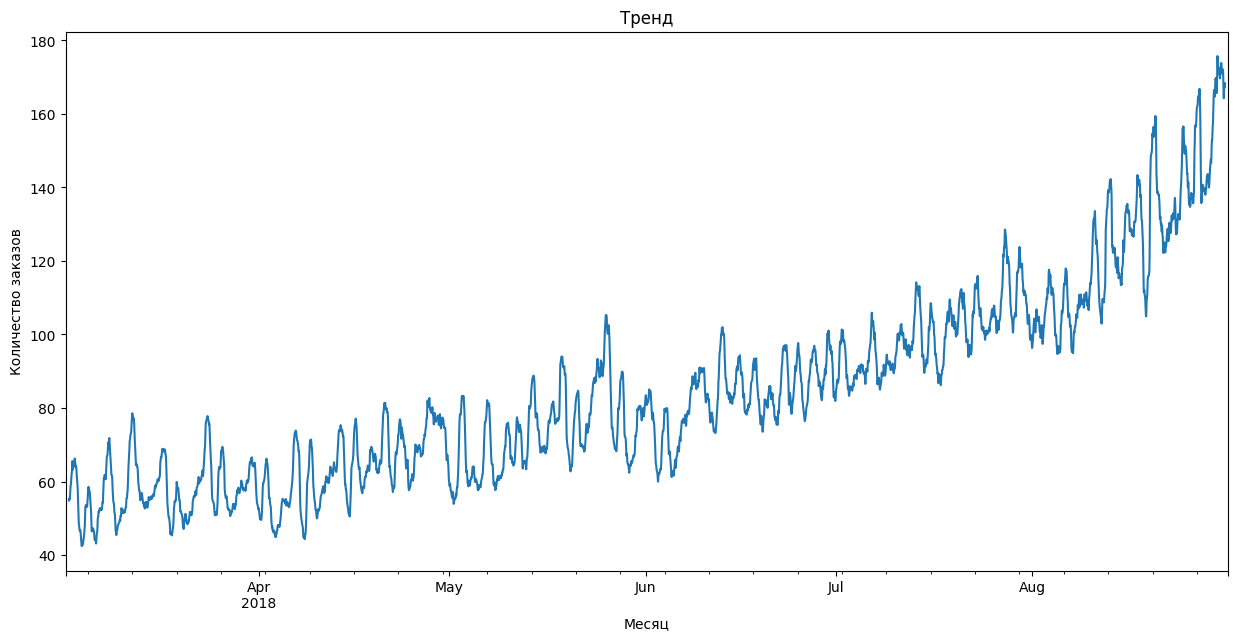

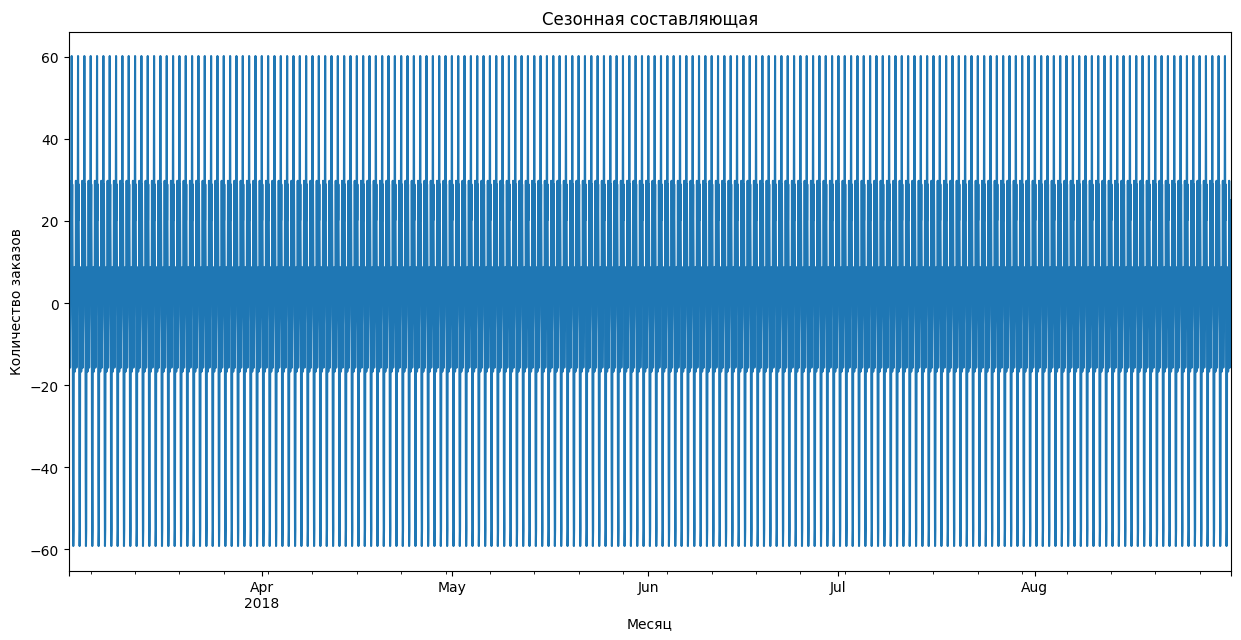

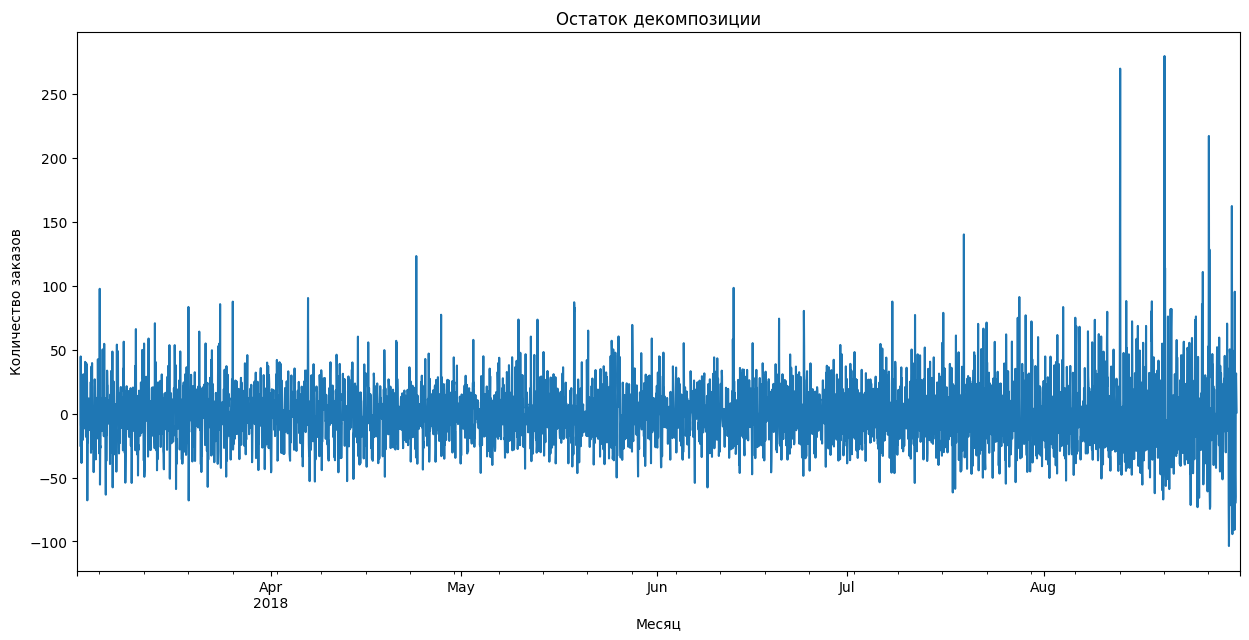

In [17]:
decomposed_data.trend.plot(figsize=figsize);
plt.title('Тренд')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data.seasonal.plot(figsize=figsize);
plt.title('Сезонная составляющая')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data.resid.plot(figsize=figsize);
plt.title('Остаток декомпозиции')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последний месяц

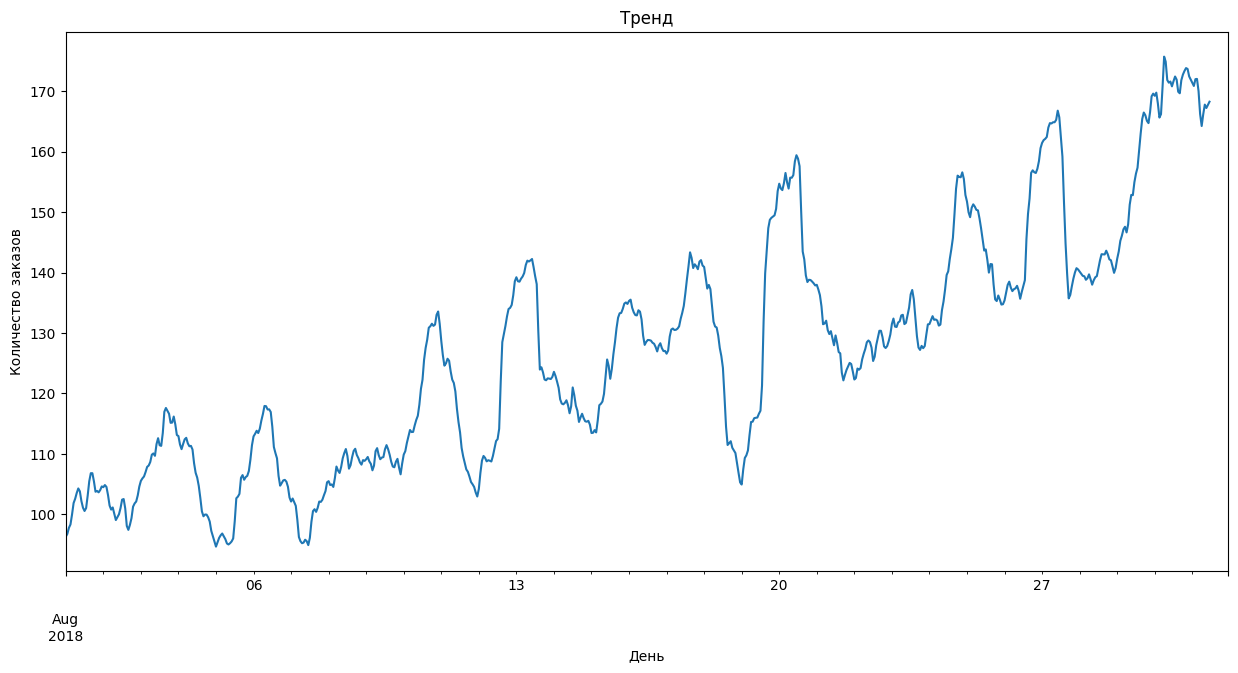

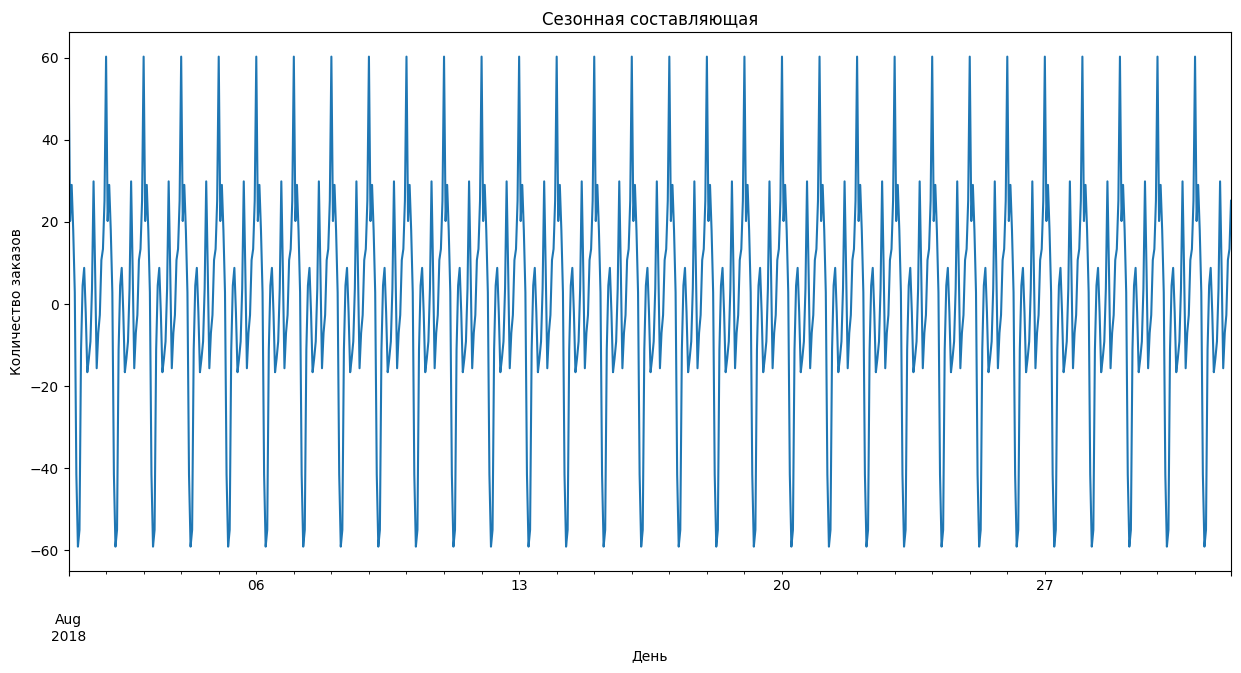

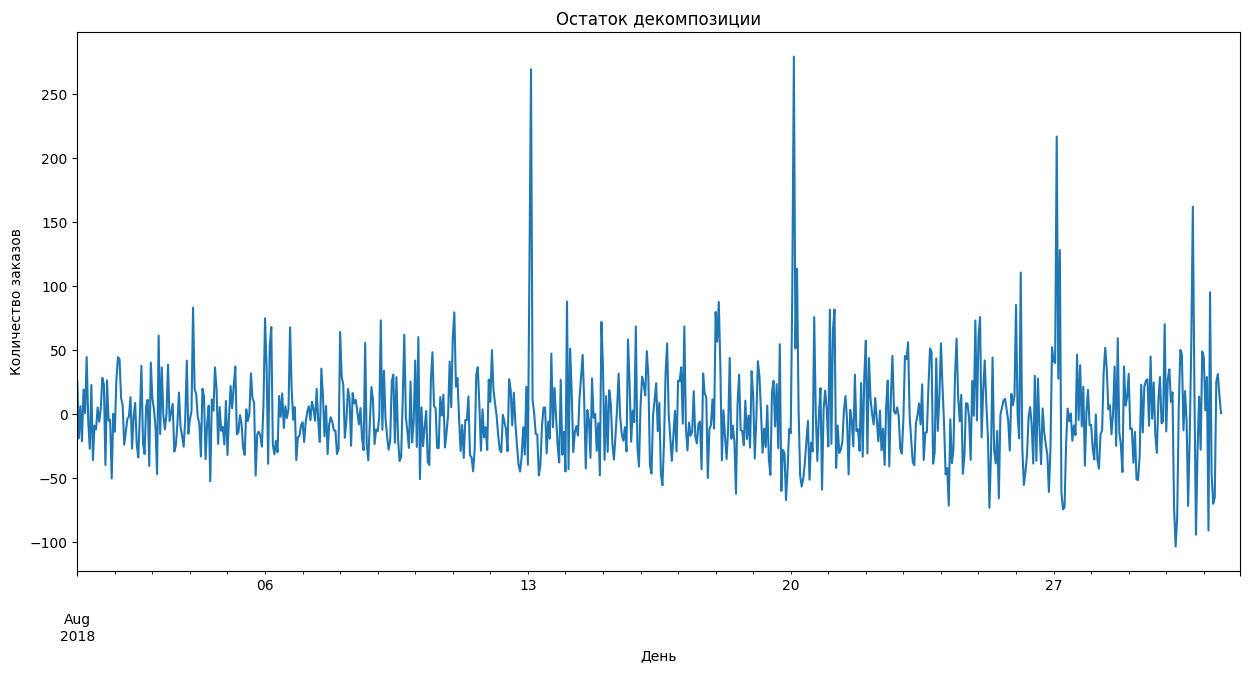

In [18]:
decomposed_data.trend['2018-08-01':].plot(figsize=figsize);
plt.title('Тренд')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data.seasonal['2018-08-01':].plot(figsize=figsize);
plt.title('Сезонная составляющая')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data.resid['2018-08-01':].plot(figsize=figsize);
plt.title('Остаток декомпозиции')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последнюю неделю

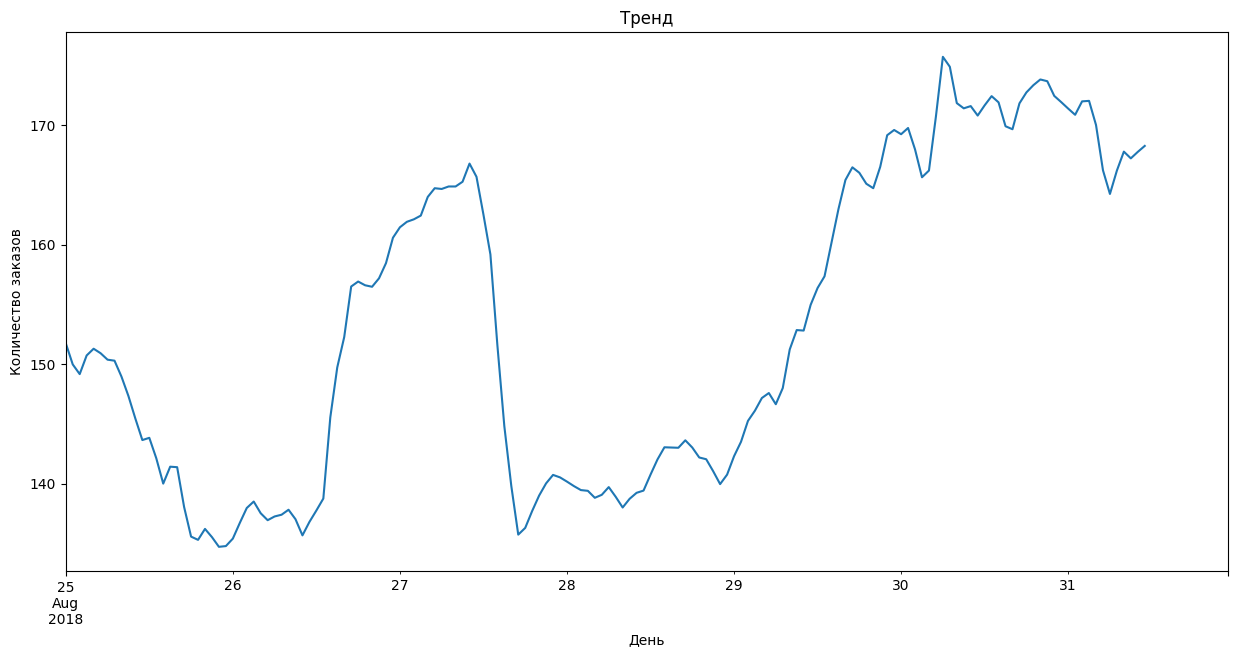

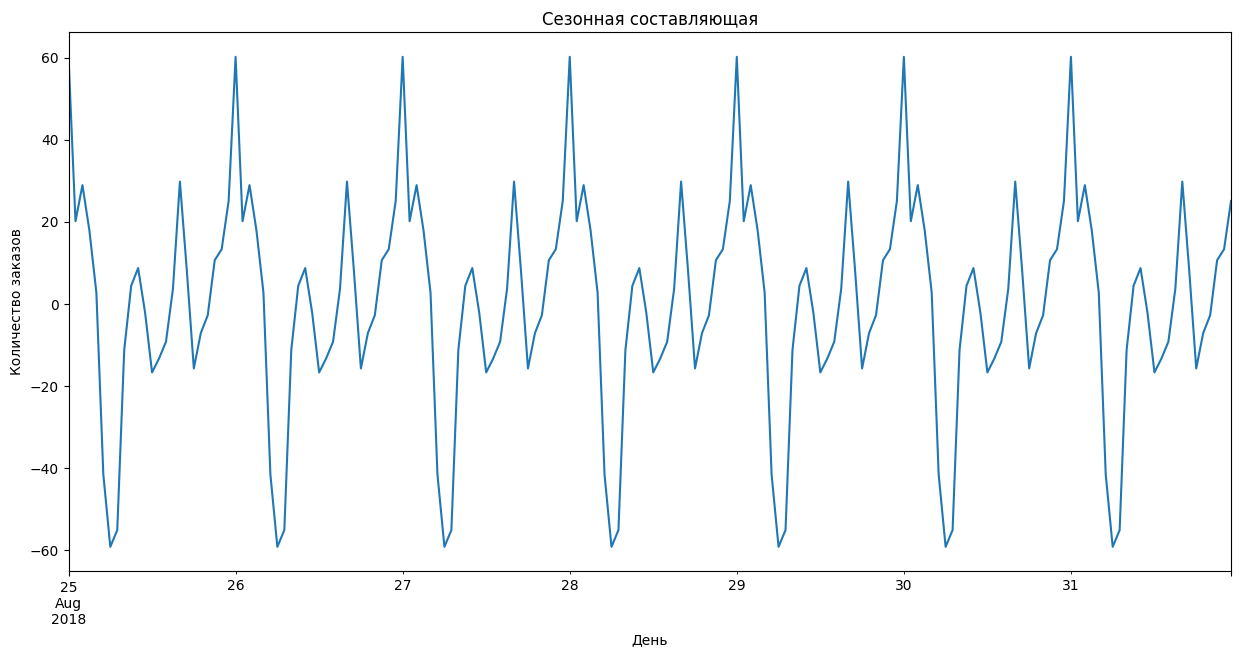

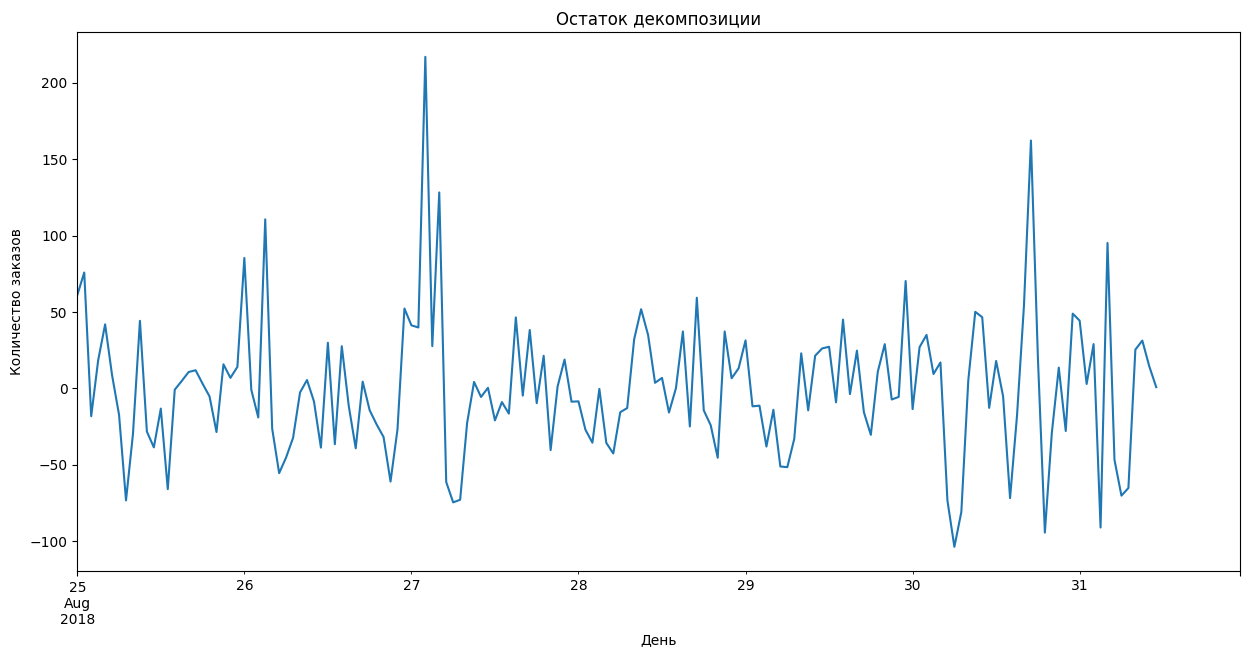

In [19]:
decomposed_data.trend['2018-08-25':].plot(figsize=figsize);
plt.title('Тренд')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data.seasonal['2018-08-25':].plot(figsize=figsize);
plt.title('Сезонная составляющая')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data.resid['2018-08-25':].plot(figsize=figsize);
plt.title('Остаток декомпозиции')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим последние 2 дня

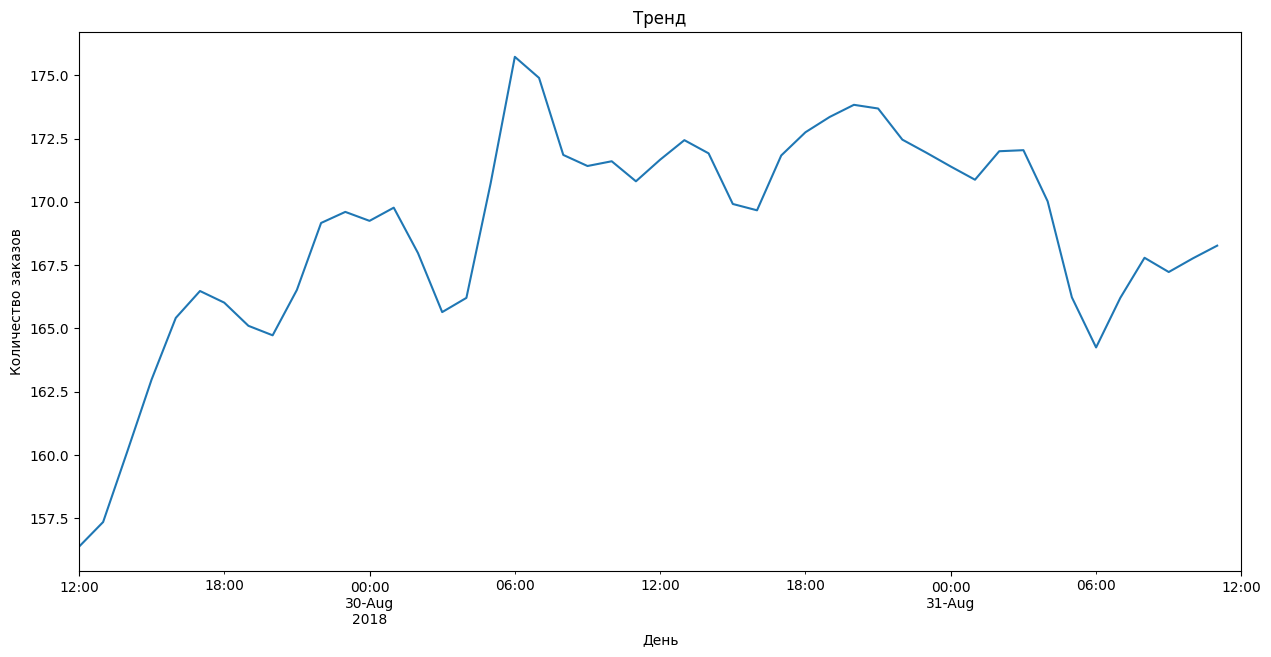

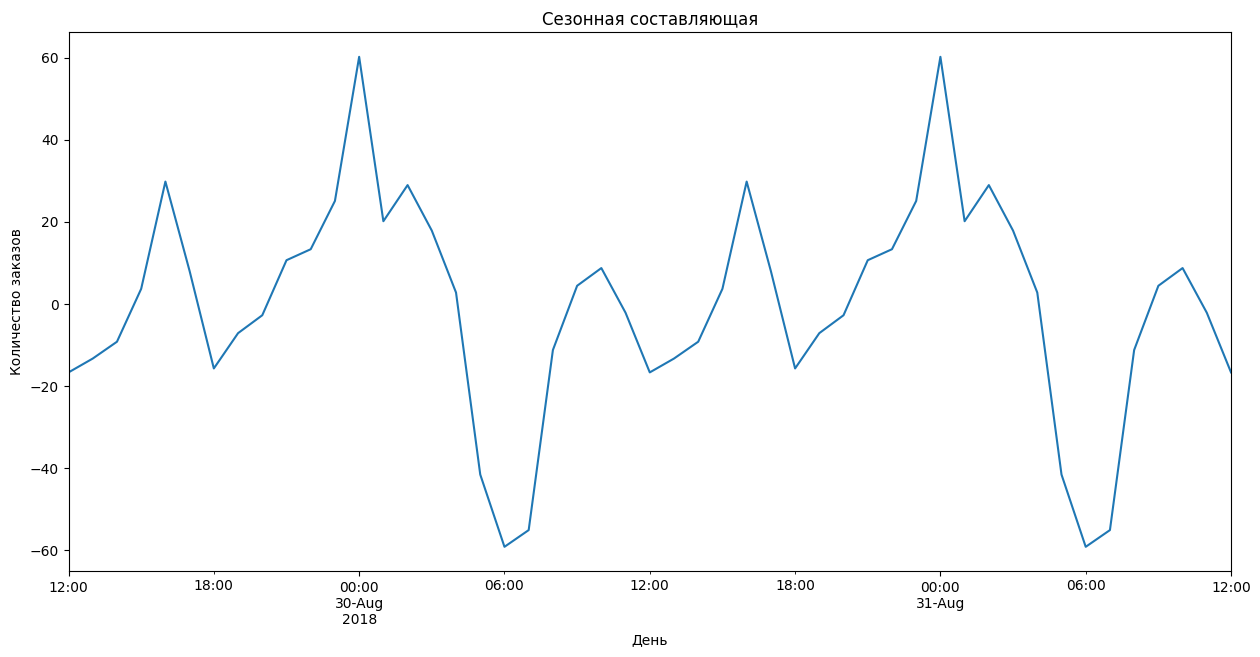

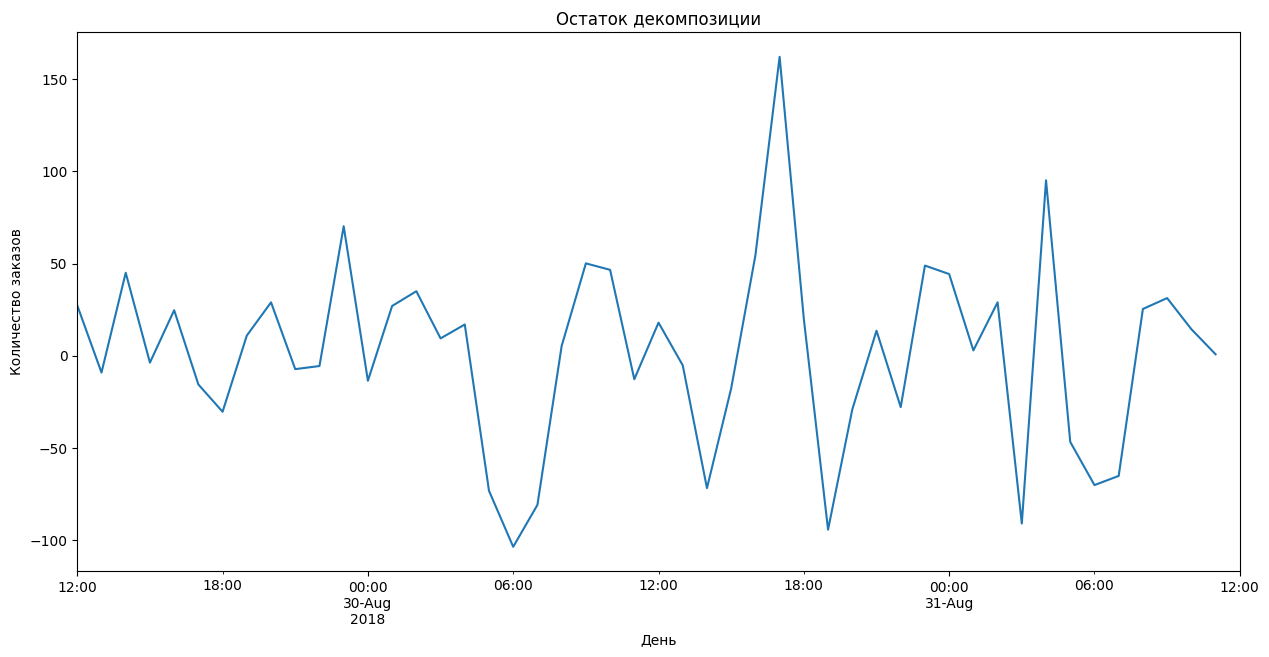

In [20]:
decomposed_data.trend['2018-08-29 12:00:00':'2018-08-31 12:00:00'].plot(figsize=figsize);
plt.title('Тренд')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data.seasonal['2018-08-29 12:00:00':'2018-08-31 12:00:00'].plot(figsize=figsize);
plt.title('Сезонная составляющая')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data.resid['2018-08-29 12:00:00':'2018-08-31 12:00:00'].plot(figsize=figsize);
plt.title('Остаток декомпозиции')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

Изучим недельную сезонность

Ресемплируем данные по одному дню

In [21]:
data1 = data.resample('1D').sum()

Проведем декомпозицию для просмотра тренда и сезонности

In [22]:
decomposed_data1 = seasonal_decompose(data1['num_orders'])

Рассмотрим последний месяц

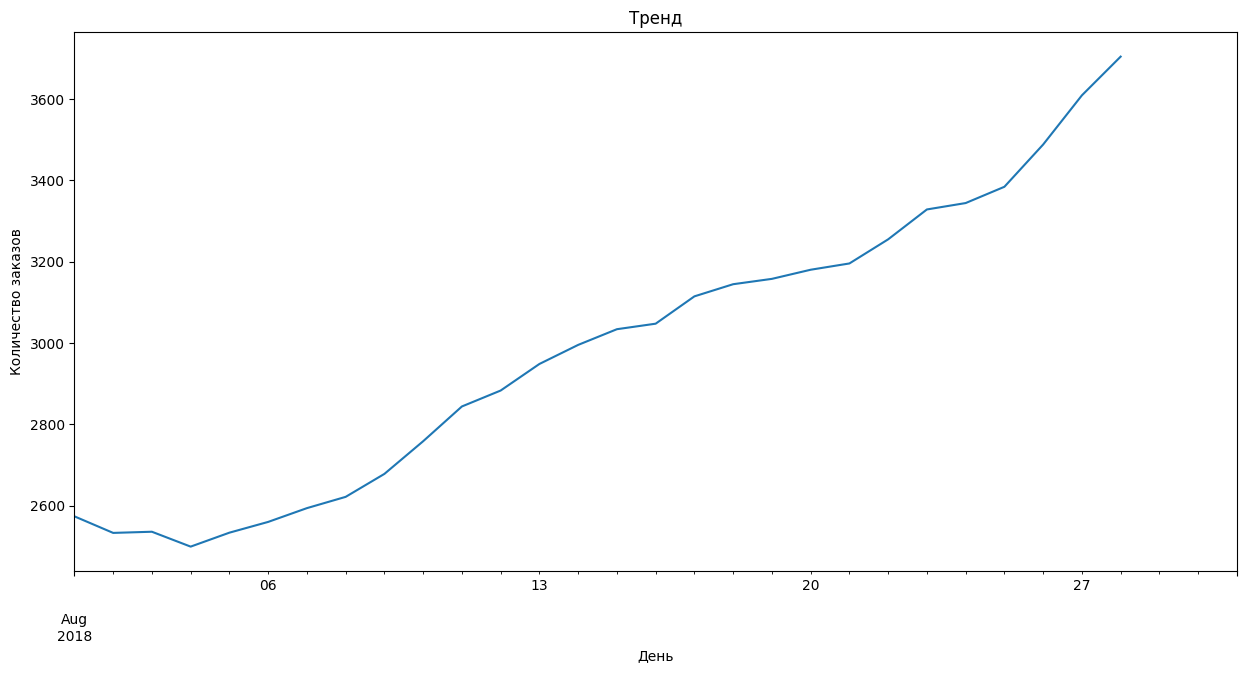

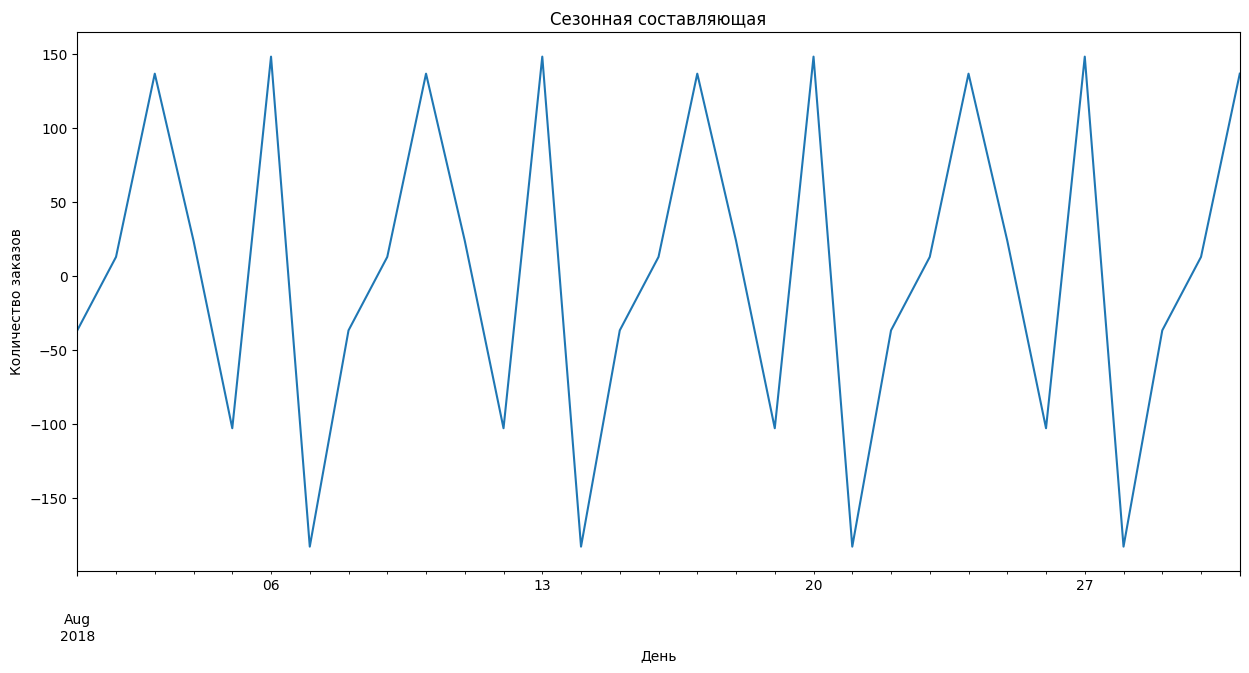

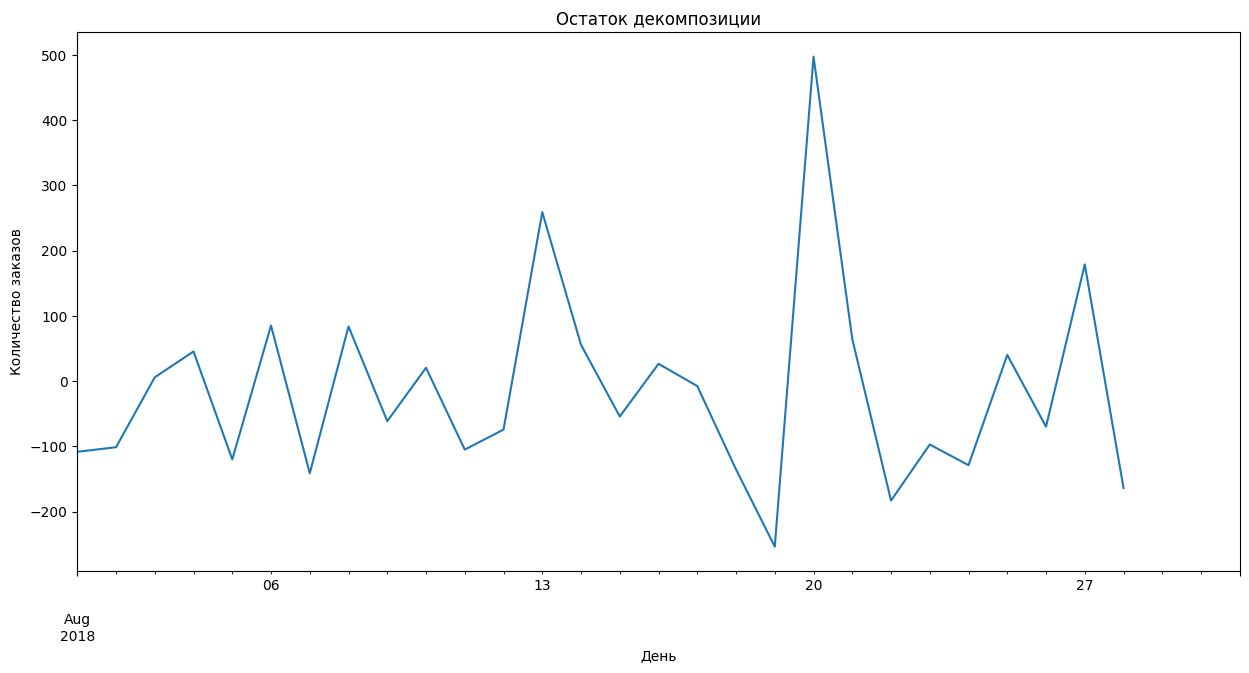

In [23]:
decomposed_data1.trend['2018-08-01':].plot(figsize=figsize);
plt.title('Тренд')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data1.seasonal['2018-08-01':].plot(figsize=figsize);
plt.title('Сезонная составляющая')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

decomposed_data1.resid['2018-08-01':].plot(figsize=figsize);
plt.title('Остаток декомпозиции')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

Определим стационарность ряда с помощью теста Дики-Фуллера

Если значение с индексом 1 меньше P-Value, заданное нами (0.05), то ряд стационарный

In [24]:
st_test = adfuller(data['num_orders'], regression='ctt')

if st_test[1] < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Ряд стационарный


Итоги анализа

* Ряд стационарный
* Сезонность в данных - сутки
* Так же присутствует недельная сезонность
* Минимум заказов приходится на вторник и воскресенье
* Максимум заказов приходится на понедельник и пятницу
* Минимум заказов приходится на 06:00, 12:00 и 18:00
* Максимум заказов приходится на 10:00, 17:00 и 00:00
* С учетом того что данные содержат заказы такси в аэропорту, вероятно время максимального и минимального числа заказов связано с работой общественного транспорта (ночью и в "час-пик" клиентам приходится пользоваться услугами такси)
* Для обучения понадобятся признаки:
    * День недели
    * День
    * Час
    * Отстающие значения
    * Скользящее среднее

## Обучение

Подберем значения lag и rolling

Наши данные рессмеиплированы по одному часу

Так как сезонность в данных сутки - возьмем значение rolling = 24 (24 часа)

В связи с тем, что в данных присутствует недельная сезонная составляющая вероятно lag стоит взять равным 168 (24 часа х 7 дней)

Проверим нашу теорию про lag на графике автокорреляции

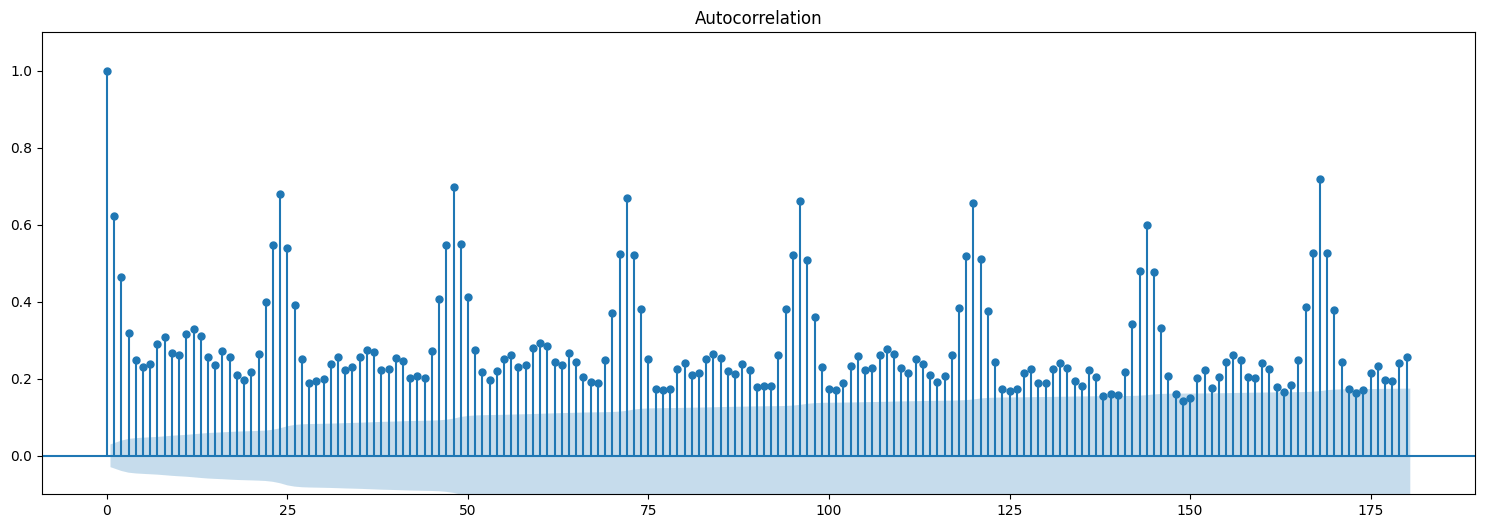

In [25]:
fig = tsaplots.plot_acf(data['num_orders'],lags= 180)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

У lag = 168 самый высокий уровень корреляции, наша теория про lag верна 

Создадим необходимые признаки

In [26]:
max_lag = 168
rolling_mean_size = 24

data['dayofweek'] = data.index.dayofweek
data['day'] = data.index.day
data['hour'] = data.index.hour

for lag in range(1, max_lag + 1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Разделим данные для обучения

In [27]:
target = 'num_orders'

train, test = train_test_split(data, shuffle=False, test_size=.2, random_state=r_state)
train = train.dropna()
    
features_train = train.drop([target], axis=1)
target_train = train[target]
    
features_test = test.drop([target], axis=1)
target_test = test[target]

features_list = {'features_train' : features_train,
                 'features_test' : features_test}
targets_list = {'target_train' : target_train,
                'target_test' : target_test}

print('Вспомогательные признаки:')
print()
for i in features_list:
    sh = features_list[i].shape
    psh = sh[0]/len(data)
    print('{} - Объектов: {} шт., признаков: {} шт. - {:.2%}'.format(i, sh[0], sh[1], psh))
    print('Начальный индекс:', features_list[i].index[0])
    print()
    
print()

print('Целевые признаки:')
print()
for i in targets_list:
    sh = targets_list[i].shape
    psh = sh[0]/len(data)
    print('{} - Объектов: {} шт. - {:.2%}'.format(i, sh[0], psh))
    print('Начальный индекс:', targets_list[i].index[0])
    print()

Вспомогательные признаки:

features_train - Объектов: 3355 шт., признаков: 173 шт. - 76.18%
Начальный индекс: 2018-03-08 12:00:00

features_test - Объектов: 881 шт., признаков: 173 шт. - 20.00%
Начальный индекс: 2018-07-26 07:00:00


Целевые признаки:

target_train - Объектов: 3355 шт. - 76.18%
Начальный индекс: 2018-03-08 12:00:00

target_test - Объектов: 881 шт. - 20.00%
Начальный индекс: 2018-07-26 07:00:00



Создадим переменную для хранения статистики

In [28]:
stat = []

In [29]:
tscv = TimeSeriesSplit(n_splits=5)

### Linear Regression

Подберем лучшие параметры для обучения, обучим модель и сохраним статистику

In [30]:
model_lr = LinearRegression()
model_lr_params = {'normalize':[True, False]}

grid_model_lr = GridSearchCV(model_lr, model_lr_params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_model_lr.fit(features_train, target_train)

print(grid_model_lr.best_params_)

rmse_lr = round(abs(grid_model_lr.best_score_), 5)
stat.append(['Linear regression', rmse_lr])

# {'normalize': True}

{'normalize': True}


### Random Forest Regressor

Подберем лучшие параметры для обучения, обучим модель и сохраним статистику

In [31]:
forest = RandomForestRegressor()
forest_params = {'n_estimators': range(5,50,10),
              'max_depth': range(1,21,5), 
              'min_samples_leaf': range(2,6,2), 
              'min_samples_split': range(2,6,2)}


grid_forest = GridSearchCV(forest, forest_params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_forest.fit(features_train, target_train)

print(grid_forest.best_params_)

rmse_forest = round(abs(grid_forest.best_score_), 5)
stat.append(['Random forest', rmse_forest])


# {'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 45}

{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 45}


### LightGBMRegressor

Подберем лучшие параметры для обучения, обучим модель и сохраним статистику

In [32]:
gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=r_state)
gbm_params = {'learning_rate':[x/10 for x in range(1, 11)],
              'n_estimators': range(20, 61, 20),
              'num_leaves': range(20, 41, 10)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_gbm.fit(features_train, target_train);
        
print(grid_gbm.best_params_)

rmse_gbm = round(abs(grid_gbm.best_score_), 5)
stat.append(['LightGBM', rmse_gbm])

# {'learning_rate': 0.1, 'n_estimators': 60, 'num_leaves': 20}

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### CatBoost Regressor

Подберем лучшие параметры для обучения, обучим модель и сохраним статистику

In [33]:
cbr = CatBoostRegressor(loss_function='RMSE',silent=True, random_seed=r_state)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),
              'iterations': range(20, 60, 20),
              'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_cbr.fit(features_train, target_train);
        
print(grid_cbr.best_params_)

rmse_cbr = round(abs(grid_cbr.best_score_), 5)
stat.append(['CatBoost', rmse_cbr])

# {'depth': 5, 'iterations': 40, 'learning_rate': 0.1778279410038923}

{'depth': 5, 'iterations': 40, 'learning_rate': 0.1778279410038923}


## Анализ моделей

Создадим DataFrame со статистическими данными наших моделей

In [34]:
stat_df = pd.DataFrame(stat, columns =['Модель', 'RMSE'])
stat_df.sort_values(by='RMSE')

,Модель,RMSE
2,LightGBM,20.24249
1,Random forest,20.42289
3,CatBoost,20.47252
0,Linear regression,21.68158


Лучшая модель согласно нашему рейтингу - LightGBMRegressor.

Проверим ее на тестовой выборке

## Тестирование

In [35]:
stat_final = []

In [36]:
model_gbm = grid_gbm.best_estimator_
model_gbm_stat_final = ModelStat('LightGBM final', model_gbm)
model_gbm_stat_final.fit(features_train, target_train)
model_gbm_stat_final.predict(features_test, target_test)
stat_final.append(model_gbm_stat_final.getResult())

In [37]:
stat_df_final = pd.DataFrame(stat_final, columns =['Модель', 'RMSE'])
stat_df_final.loc[1] = stat[2]
stat_df_final

,Модель,RMSE
0,LightGBM final,36.23039
1,LightGBM,20.24249


Проверим модель на адекватность

In [38]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(rmse(target_test, pred_previous), 5))

RMSE для проверки модели на адекватность: 53.39249


Показатели нашей модели значительно лучше

Финальный тест показал хорошие результаты

Качество предсказаний немного ухудшилось по сравнению с валидационной выборкой, но при этом меньше критерия RMSE не больше 48

## Общий вывод

Проведено исследование с целью спрогнозировать количество заказов такси на следующий час

Основной критерий:
* Значение метрики RMSE на тестовой выборке не должно превышать 48

Цель исследования — спрогнозировать количество заказов такси на следующий час.

Данные получили из файла taxi.csv.

Исследование проходило в четыре этапа:

* Подготовка
* Анализ данных
* Обучение
* Анализ моделей
* Тестирование

Мы использовали модели градиетного бустинга CatBoostRegressor и LightGBM, и сравнили их с базовыми моделями LinearRegression и RandomForestRegressor

Исходя из полученных данных статистики обучения моделей:

Лучшая модель - LightGBMRegressor с финальным значением RMSE 36.23039